<a href="https://colab.research.google.com/github/stevenhastings/NFL-University/blob/main/NFL_Parquet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

# %pip install pandas pyarrow
%pip install pyspark
%pip install findspark
%pip install java

In [2]:
import pandas as pd
import json
# import pyarrow as pa 
# import pyarrow.parquet as pq
# import dask.dataframe as dd
import pyspark
import findspark
# import configparser
# import psycopg2 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
from matplotlib.animation import FuncAnimation

from pyspark.sql import SparkSession
from pyspark.sql.types import *

import numpy as np 
import seaborn as sns 

# from sklearn.model_selection import GroupKFold
# from sklearn.linear_model import LogisticRegression

# from scipy.spatial.distance import pdist, squareform
# from scipy.stats import pearsonr

In [3]:
# config = configparser.ConfigParser()
# config.read()

In [4]:
games = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/games.csv")
players = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/players.csv")
scout = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/pffScoutingData.csv")
plays = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/plays.csv")

In [5]:
week1 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week1.csv")
week2 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week2.csv")
week3 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week3.csv")
week4 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week4.csv")
week5 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week5.csv")
week6 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week6.csv")
week7 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week7.csv")
week8 = pd.read_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/week8.csv")
weeks = pd.concat([week1, week2, week3, week4, week5, week6, week7, week8])
weeks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8314178 entries, 0 to 978948
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   gameId         int64  
 1   playId         int64  
 2   nflId          float64
 3   frameId        int64  
 4   time           object 
 5   jerseyNumber   float64
 6   team           object 
 7   playDirection  object 
 8   x              float64
 9   y              float64
 10  s              float64
 11  a              float64
 12  dis            float64
 13  o              float64
 14  dir            float64
 15  event          object 
dtypes: float64(9), int64(3), object(4)
memory usage: 1.1+ GB


In [6]:
pd.set_option('display.max_columns', 100)

In [7]:
weeks = pd.merge(weeks, games, how='inner', on='gameId', validate='many_to_one')
weeks.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,2021,1,09/09/2021,20:20:00,TB,DAL
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,2021,1,09/09/2021,20:20:00,TB,DAL
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,2021,1,09/09/2021,20:20:00,TB,DAL
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,2021,1,09/09/2021,20:20:00,TB,DAL


In [ ]:
weeks = weeks.drop(columns=['gameTimeEastern', 'gameDate'])

In [11]:
weeks['advantage'] = weeks['team'] == weeks['homeTeamAbbr']
weeks

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,season,week,homeTeamAbbr,visitorTeamAbbr,advantage
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,2021,1,TB,DAL,True
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,2021,1,TB,DAL,True
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,2021,1,TB,DAL,True
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,2021,1,TB,DAL,True
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,2021,1,TB,DAL,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8314173,2021110100,4433,NaN,54,2021-11-02T03:20:26.500,NaN,football,right,24.17,27.89,2.47,2.28,0.25,NaN,NaN,None,2021,8,KC,NYG,False
8314174,2021110100,4433,NaN,55,2021-11-02T03:20:26.600,NaN,football,right,24.36,28.03,2.36,2.16,0.24,NaN,NaN,None,2021,8,KC,NYG,False
8314175,2021110100,4433,NaN,56,2021-11-02T03:20:26.700,NaN,football,right,24.55,28.17,2.25,1.45,0.23,NaN,NaN,None,2021,8,KC,NYG,False
8314176,2021110100,4433,NaN,57,2021-11-02T03:20:26.800,NaN,football,right,24.73,28.31,2.28,0.72,0.23,NaN,NaN,None,2021,8,KC,NYG,False


In [12]:
weeks.to_csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/FW.csv")

In [48]:
labels = [
    ('_id', IntegerType()),
    ('gameId', IntegerType()),
    ('playId', IntegerType()),
    ('nflId', FloatType()),
    ('frameId', IntegerType()), 
    ('time', TimestampType()), 
    ('jerseyNumber', FloatType()), 
    ('team', StringType()),
    ('playDirection', StringType()), 
    ('x', FloatType()), 
    ('y', FloatType()), 
    ('s', FloatType()), 
    ('a', FloatType()), 
    ('dis', FloatType()), 
    ('o', FloatType()), 
    ('dir', FloatType()), 
    ('event', StringType()),
    ('season', IntegerType()),
    ('week', IntegerType()),
    ('home', StringType()),
    ('away', StringType()),
    ('advantage', StringType())
    ]
schema = StructType([StructField (i[0],i[1],True) for i in labels])


In [49]:
spark = SparkSession.builder.appName("nfl_verse").getOrCreate()

In [50]:
tracking = spark.read.csv("/content/drive/MyDrive/NFL_DATA/data/tracking_data/FW.csv", schema=schema, header=True)

In [51]:
tracking.show()

+---+----------+------+-------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+---------+------+----+----+----+---------+
|_id|    gameId|playId|  nflId|frameId|                time|jerseyNumber|team|playDirection|    x|    y|   s|   a| dis|     o|   dir|    event|season|week|home|away|advantage|
+---+----------+------+-------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+---------+------+----+----+----+---------+
|  0|2021090900|    97|25511.0|      1|2021-09-10 00:26:...|        12.0|  TB|        right|37.77|24.22|0.29| 0.3|0.03|165.16| 84.99|     None|  2021|   1|  TB| DAL|     True|
|  1|2021090900|    97|25511.0|      2|2021-09-10 00:26:...|        12.0|  TB|        right|37.78|24.22|0.23|0.11|0.02|164.33| 92.87|     None|  2021|   1|  TB| DAL|     True|
|  2|2021090900|    97|25511.0|      3|2021-09-10 00:26:...|        12.0|  TB|        right|37.78|24.24|0.16| 0.1|0.01|1

In [19]:
# tracking.write.parquet("/content/drive/MyDrive/NFL_DATA/data/tracking_data/FULLweeks1.parquet")

# df = spark.read.format("parquet").load("/content/drive/MyDrive/NFL_DATA/data/tracking_data/FULLweeks1.parquet")

In [52]:
print(f"{tracking.count():,d}")

8,314,178


In [54]:
tracking.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- nflId: float (nullable = true)
 |-- frameId: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- jerseyNumber: float (nullable = true)
 |-- team: string (nullable = true)
 |-- playDirection: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- s: float (nullable = true)
 |-- a: float (nullable = true)
 |-- dis: float (nullable = true)
 |-- o: float (nullable = true)
 |-- dir: float (nullable = true)
 |-- event: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- home: string (nullable = true)
 |-- away: string (nullable = true)
 |-- advantage: string (nullable = true)



In [55]:
tracking.show()

+---+----------+------+-------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+---------+------+----+----+----+---------+
|_id|    gameId|playId|  nflId|frameId|                time|jerseyNumber|team|playDirection|    x|    y|   s|   a| dis|     o|   dir|    event|season|week|home|away|advantage|
+---+----------+------+-------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+---------+------+----+----+----+---------+
|  0|2021090900|    97|25511.0|      1|2021-09-10 00:26:...|        12.0|  TB|        right|37.77|24.22|0.29| 0.3|0.03|165.16| 84.99|     None|  2021|   1|  TB| DAL|     True|
|  1|2021090900|    97|25511.0|      2|2021-09-10 00:26:...|        12.0|  TB|        right|37.78|24.22|0.23|0.11|0.02|164.33| 92.87|     None|  2021|   1|  TB| DAL|     True|
|  2|2021090900|    97|25511.0|      3|2021-09-10 00:26:...|        12.0|  TB|        right|37.78|24.24|0.16| 0.1|0.01|1

In [56]:
# register dataframe as a SQL/temporary view 
tracking.createOrReplaceTempView('nfl')

In [67]:
home_team = spark.sql("SELECT * FROM nfl WHERE gameId = 2021092300 and playId = 54 and frameId = 1 and advantage = True ORDER BY time ASC")

In [84]:
home_team.select('x').show()

+-----+
|    x|
+-----+
|38.66|
|38.62|
|39.55|
| 35.3|
|35.82|
|35.57|
|35.08|
|37.24|
|52.29|
| 35.4|
|35.81|
+-----+



In [69]:
away_team = spark.sql("SELECT * FROM nfl WHERE gameId = 2021092300 and playId = 54 and frameId = 1 and advantage = False and team != 'football' ORDER BY time ASC")

football = spark.sql("SELECT * FROM nfl WHERE gameId = 2021092300 and playId = 54 and frameId = 1 and team = 'football' ORDER BY time ASC")

In [70]:
away_team.show()

+-------+----------+------+-------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+-----+------+-----+------+----+----+----+---------+
|    _id|    gameId|playId|  nflId|frameId|                time|jerseyNumber|team|playDirection|    x|    y|   s|   a| dis|    o|   dir|event|season|week|home|away|advantage|
+-------+----------+------+-------+-------+--------------------+------------+----+-------------+-----+-----+----+----+----+-----+------+-----+------+----+----+----+---------+
|2160927|2021092300|    54|41436.0|      1|2021-09-24 00:23:...|        61.0| CAR|        right| 34.3|30.15| 0.0| 0.0| 0.0|91.65|255.07| None|  2021|   3| HOU| CAR|    False|
|2160989|2021092300|    54|42362.0|      1|2021-09-24 00:23:...|        75.0| CAR|        right|33.33|33.32| 0.0| 0.0| 0.0|80.41|234.11| None|  2021|   3| HOU| CAR|    False|
|2161020|2021092300|    54|42424.0|      1|2021-09-24 00:23:...|        67.0| CAR|        right|33.68|28.38| 0.0| 0.0| 0.0|94

In [71]:
football.show()

+-------+----------+------+-----+-------+--------------------+------------+--------+-------------+-----+-----+---+---+---+----+----+-----+------+----+----+----+---------+
|    _id|    gameId|playId|nflId|frameId|                time|jerseyNumber|    team|playDirection|    x|    y|  s|  a|dis|   o| dir|event|season|week|home|away|advantage|
+-------+----------+------+-----+-------+--------------------+------------+--------+-------------+-----+-----+---+---+---+----+----+-----+------+----+----+----+---------+
|2161578|2021092300|    54| null|      1|2021-09-24 00:23:...|        null|football|        right|34.81|30.04|0.0|0.0|0.0|null|null| None|  2021|   3| HOU| CAR|    False|
+-------+----------+------+-----+-------+--------------------+------------+--------+-------------+-----+-----+---+---+---+----+----+-----+------+----+----+----+---------+



# Plotting the field

In [72]:
def generate_field():

    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=2,
                            edgecolor='black', facecolor='green', zorder=0)

    fig, ax = plt.subplots(1, figsize=(12, 5.33))
    ax.add_patch(rect)

    # plot line numbers
    for a in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]:
        ax.axvline(x=a, color='white')

    # added to set y-axis up for the numbers
    ax.axhline(y=0, color='white')
    ax.axhline(y=53.3, color='white')

    # plot numbers 
    for x in range(20, 110, 10):
        numb = x
        if x > 50:
            numb = 120-x
        ax.text(x, 5, str(numb - 10), horizontalalignment='center', fontsize=20, color='white')
        ax.text(x-0.95, 53.3-5, str(numb-10),
                horizontalalignment='center', fontsize=20, color='white', rotation=180)
        
    # hash marks
    for x in range(11, 110):
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [23, 23.66], color='white')
        ax.plot([x, x], [29.66, 30.33], color='white')

    # hide axis
    plt.axis('off')

    return fig, ax

In [79]:
home_team.x

Column<'x'>

In [88]:
from pyspark.sql.functions import col

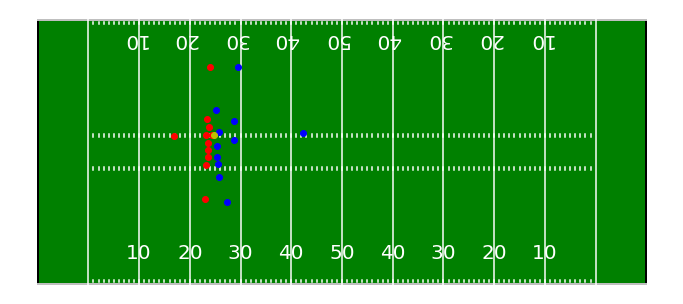

In [92]:
fig, ax = generate_field()

spark_home = home_team.select(['x', 'y'])
pandas_home = spark_home.toPandas()
spark_away = away_team.select(['x', 'y'])
pandas_away = spark_away.toPandas()
spark_football = football.select(['x', 'y'])
pandas_football = spark_football.toPandas()

# visualize positions with scatter plot 
ax.plot(pandas_home['x'], pandas_home['y'], 'bo')
ax.plot(pandas_away['x'], pandas_away['y'], 'ro')
ax.plot(pandas_football['x'], pandas_football['y'], 'yo')



# Draw the Play in Function

In [117]:
def draw_play(game_id, play_id, frame):
    # query tracking data for the home team
    home_team = spark.sql(f"SELECT * FROM nfl WHERE gameId = {game_id} and playId = {play_id} and frameId = {frame} and advantage = True ORDER BY time ASC")

    away_team = spark.sql(f"SELECT * FROM nfl WHERE gameId = {game_id} and playId = {play_id} and frameId = {frame} and advantage = False and team != 'football' ORDER BY time ASC")

    football = spark.sql(f"SELECT * FROM nfl WHERE gameId = {game_id} and playId = {play_id} and frameId = {frame} and team = 'football' ORDER BY time ASC")

    total_frames = spark.sql(f"SELECT MAX(frameId) FROM nfl WHERE gameId = {game_id} and playId = {play_id}")

    # Convert to pandas for plotting
    spark_home = home_team.select(['x', 'y'])
    pandas_home = spark_home.toPandas()

    spark_away = away_team.select(['x', 'y'])
    pandas_away = spark_away.toPandas()

    spark_football = football.select(['x', 'y'])
    pandas_football = spark_football.toPandas()

    # visualize positions with scatter plot 
    ax.plot(pandas_home['x'], pandas_home['y'], 'bo')
    ax.plot(pandas_away['x'], pandas_away['y'], 'ro')
    ax.plot(pandas_football['x'], pandas_football['y'], 'yo')

In [150]:
def total_frames(game_id, play_id):
    tf = spark.sql(f"SELECT MAX(frameId) FROM nfl WHERE gameId = {game_id} and playId = {play_id}")
    pd_tf = tf.toPandas()
    return pd_tf['max(frameId)'][0]

In [151]:
total_frames(game_id=2021092300, play_id=54)

31

# Animate

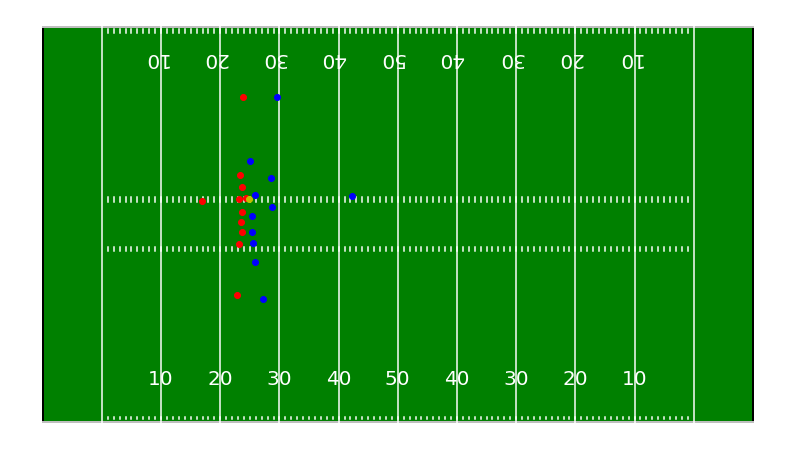

In [161]:
fig, ax = generate_field()

def update_plot(l):
    draw_play(game_id=2021092300,
              play_id=54,
              frame=1)
    
anim = FuncAnimation(fig, update_plot, frames=31, interval=1)
fig.set_figheight(8)
fig.set_figwidth(14)
plt.show()